In [1]:
using Revise, UnboundedBNN, Plots, Random, Optimisers, ProgressMeter, Zygote, LinearAlgebra, BenchmarkTools, PProf, Profile

In [2]:
function generate_samples(N, ω; seed=42, T=Float32)
    t = rand(MersenneTwister(seed), T, N)
    u = sqrt.(t)
    y = rand(MersenneTwister(seed), (-1, 1), N)
    x = zeros(T, 2, N)
    for n in 1:N
        tmp = randn(MersenneTwister(seed+n), T, 2)
        x[1, n] = y[n] * u[n] * cos(ω * u[n] * convert(T, pi) / 2) + convert(T, 0.02) * tmp[1]
        x[2, n] = y[n] * u[n] * sin(ω * u[n] * convert(T, pi) / 2) + convert(T, 0.02) * tmp[2]
    end
    return x, y
end

generate_samples (generic function with 1 method)

In [3]:
N = 8192
ω = 1
x_train, y_train = generate_samples(N, ω)
x_test,  y_test  = generate_samples(N, ω; seed=123456);

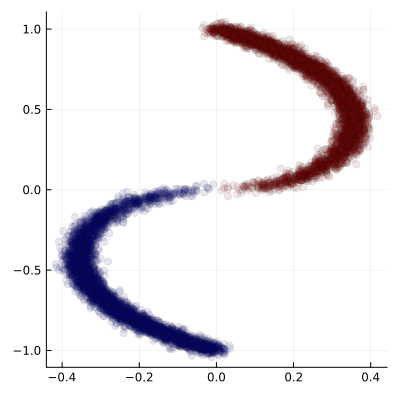

In [4]:
plot(x_train[1,:], x_train[2,:], seriestype=:scatter, zcolor=y_train, legend=false, color=:jet; alpha=0.1, size=(400, 400))

In [5]:
function binarycrossentropy(p::BitMatrix, q::Matrix)
    return -mean(q .* p)
end

binarycrossentropy (generic function with 1 method)

In [6]:
to_one_hot(p) = vcat((p .== -1)', (p .== 1)')

to_one_hot (generic function with 1 method)

In [7]:
function predict(model, x; nr_evals=100)
    posterior = UnboundedBNN.transform(model.posterior)
    lower, upper = UnboundedBNN.support(posterior)
    post_pdf = UnboundedBNN.pmf.(Ref(posterior), lower:upper)

    logln = zeros(Float64, 2, size(x, 2))
    for k in 1:nr_evals
        output = model(x)
        logln += mapreduce(l -> output[l] .* post_pdf[l], +, 1:length(post_pdf))
    end
    return [getindex.(argmax(logln, dims=1), 1)...] .* 2 .- 3
end

predict (generic function with 1 method)

In [8]:
function loss(y::BitMatrix, x::Matrix{T}, model; batch_prop = 1.0f0) where {T}
    
    posterior = UnboundedBNN.transform(model.posterior)
    lower, upper = UnboundedBNN.support(posterior)
    post_pdf = UnboundedBNN.pmf.(Ref(posterior), lower:upper)

    output = model(x)
    # logln = mapreduce(l -> map(o -> o * post_pdf[l], output[l]), +, 1:length(post_pdf)) :: Matrix{T}
    logln = mapreduce(l -> post_pdf[l] .* output[l], +, 1:length(post_pdf)) :: Matrix{T}

    kl_poisson = KL_loss(posterior, model.prior)
    kl_input = KL_loss(model.input_layer)
    # kl_hidden = mapreduce(l -> dot(post_pdf[1:l], map(li -> KL_loss(model.hidden_layers[li]), 1:l)), +, 1:length(post_pdf))
    # kl_hidden = mapreduce(l -> post_pdf[l] * KL_loss(model.hidden_layers[l]), +, 1:length(post_pdf))
    # kl_output = mapreduce(l -> post_pdf[l] * KL_loss(model.output_layers[l]), +, 1:length(post_pdf))
    # kl_output = mapreduce(l -> post_pdf[l] * KL_loss(model.output_layers[l]), +, 1+lower:1+upper)
    kl_hidden = mapreduce(l -> post_pdf[l-lower+1] * sum(li -> KL_loss(model.hidden_layers[li]), 1:l+1), +, lower:upper)
    kl_output = mapreduce(l -> post_pdf[l-lower+1] * KL_loss(model.output_layers[l+1]), +, lower:upper)
    kl_total = kl_poisson + kl_input + kl_output + kl_hidden
    return binarycrossentropy(y, logln) + batch_prop * kl_total

end

loss (generic function with 1 method)

In [9]:
dimin = 2
dimmid = 4
dimout = 2

max_layers = 30

expansion_layer = Chain(LinearBBB(dimin => dimmid), LeakyReLU())
intermediate_layer = ntuple(_ -> Chain(LinearBBB(dimmid => dimmid), LeakyReLU()), max_layers)
output_layer = ntuple(_ -> Chain(LinearBBB(dimmid => dimout), Softmax(dimout)), max_layers)

prior = discretize(H() * Normal(0.0f0 , 2.0f0))
posterior = TransformedDistribution(
    SafeNormal([0.0f0], [invsoftplus(2.0f0)]), 
    (
        x -> H() * x,
        x -> truncate_to_quantiles(x, 0.025f0, 0.975f0),
        x -> expand_truncation_to_ints(x),
        x -> discretize(x)
    )
)

model = Unbounded(
    expansion_layer,
    intermediate_layer,
    output_layer, 
    prior, posterior)

opt = Optimisers.setup(Adam(), model)
Optimisers.adjust!(opt, 0.005f0)
Optimisers.adjust!(opt.posterior, 0.0005f0)

In [10]:
accuracy(y::Vector, yhat::Vector) = mean(y .== yhat)

accuracy (generic function with 1 method)

In [11]:
epochs = 1000
batch_size = 256
loss_train = zeros(epochs)
loss_test  = zeros(epochs)
y_train_onehot = to_one_hot(y_train)
y_test_onehot = to_one_hot(y_test)
gs = nothing
@showprogress for e in 1:epochs
    for n in Iterators.partition(randperm(N), batch_size)
        _, gs = Zygote.withgradient(m -> loss(y_train_onehot[:,n], x_train[:,n], m; batch_prop = convert(Float32, length(n)/N)), model)
        opt, model = Optimisers.update!(opt, model, gs[1])
    end
    loss_train[e] = loss(y_train_onehot, x_train, model)
    loss_test[e] = loss(y_test_onehot, x_test, model)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:02:18


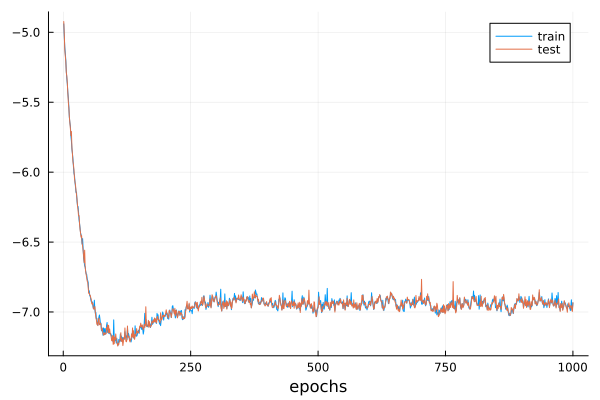

In [12]:
plot(log.(loss_train) .- log(N), label="train")
plot!(log.(loss_test) .- log(N), label="test")
xlabel!("epochs")

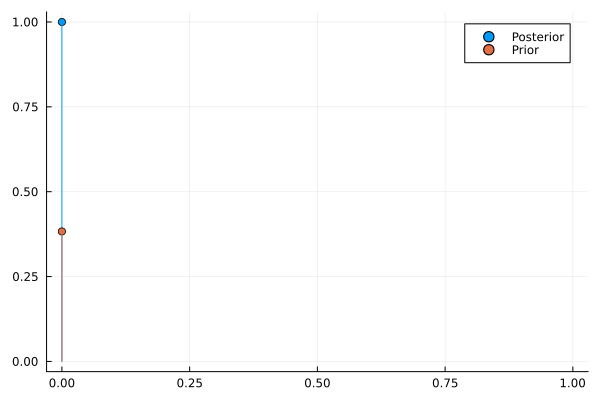

In [13]:
let 
    posterior = UnboundedBNN.transform(model.posterior)
    lower, upper = UnboundedBNN.support(posterior)
    post_pdf = UnboundedBNN.pmf.(Ref(posterior), lower:upper)
    plot(lower:upper, post_pdf, line=:stem, marker=:circle, label="Posterior")
    plot!(lower:upper, UnboundedBNN.pmf.(Ref(model.prior), lower:upper), line=:stem, marker=:circle, label="Prior")
end

Accuracy: 0.9991455078125


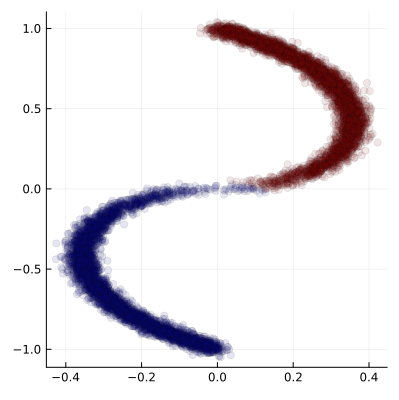

In [14]:
let 
    predictions = predict(model, x_test)
    println("Accuracy: ", accuracy(y_test, predict(model, x_test)))
    plot(x_test[1,:], x_test[2,:], seriestype=:scatter, zcolor=predictions, legend=false, color=:jet; alpha=0.1, size=(400, 400))
end